# Usage

Import AISim plus numpy and matplotlib and print current version:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aisim as ais
from functools import partial

As an example, we simulate Rabi oscillations driven by stimulated Raman transitions in the presence of thermal motion.

First, we define a `AtomicEnsemble` object for atoms from a magneto-optical trap after sub-Doppler cooling:

In [2]:
atoms = ais.create_random_ensemble(
    int(1e4),
    x_dist=partial(ais.dist.position_dist_gaussian, std=3.0e-3),
    y_dist=partial(ais.dist.position_dist_gaussian, std=3.0e-3),
    z_dist=partial(ais.dist.position_dist_gaussian, std=3.0e-3),
    vx_dist=partial(ais.dist.velocity_dist_from_temp, temperature=3.0e-6),
    vy_dist=partial(ais.dist.velocity_dist_from_temp, temperature=3.0e-6),
    vz_dist=partial(ais.dist.velocity_dist_from_temp, temperature=150e-9),
    seed=1,
)

Only a fraction of these atoms will be detected after a time-of-flight of 800 ms. We model the detection region with radius of 5 mm:

In [3]:
det = ais.SphericalDetector(t_det=800e-3, r_det=5e-3)

We select the atoms that are eventually detected, let those freely propagate for 100 ms

In [4]:
atoms = det.detected_atoms(atoms)
free_prop = ais.FreePropagator(100e-3)
atoms = free_prop.propagate(atoms)

We setup the two counter-propagating Raman laser beams with a wavelength of 780 nm, 30 mm beam diameter and a Rabi frequency of 15 kHz as  `IntensityProfile` and `WaveVectors` objects and finally create a `TwoL` that propagates the atomic system by 1 μs while the light is turned on.

In [5]:
intensity_profile = ais.IntensityProfile(
    r_profile=15e-3, center_rabi_freq=2 * np.pi * 15e3
)

wave_vectors = ais.Wavevectors(k1=2 * np.pi / 780e-9, k2=-2 * np.pi / 780e-9)

time_delta = 1e-6
prop = ais.TwoLevelTransitionPropagator(
    time_delta, intensity_profile=intensity_profile, wave_vectors=wave_vectors
)

Now, we start the Rabi oscillations up to 200 μs:

In [6]:
state_occupation = []
taus = np.arange(200) * time_delta
for tau in taus:
    atoms = prop.propagate(atoms)
    mean_occupation = np.mean(atoms.state_occupation(state=1))
    state_occupation.append(mean_occupation)

Finally, we plot the results:

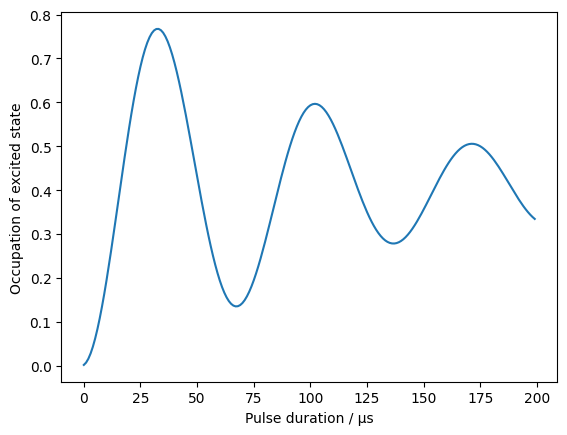

In [7]:
fig, ax = plt.subplots()
ax.plot(1e6 * taus, state_occupation)
ax.set_xlabel("Pulse duration / μs")
ax.set_ylabel("Occupation of excited state");

We visualize the spread of the atomic ensemble and its convolution with the detector.

In [8]:
fig.savefig("rabi-oscillations.png")